In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10) # setting default figure size
pylab.style.use('ggplot') # setting style

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from Backtester.SignalLibrary import Signals as sl
import PyDSWS
ds = PyDSWS.Datastream(username="ZONT033", password="MOTOR506")
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [3]:
freq = 'D'
fxfwd_tickers = ['TDCAD3M', 'TDAUD3M', 'TDCHF3M', 'TDEUR3M',
                 'TDGBP3M', 'TDJPY3M', 'TDNOK3M', 'TDNZD3M',
                 'TDSEK3M', 'NBITL3F', 'NBFRF3F', 'NBDEM3F']

fxsp_tickers = ['TDCADSP', 'TDAUDSP', 'TDCHFSP', 'TDEURSP',
                'TDGBPSP', 'TDJPYSP', 'TDNOKSP', 'TDNZDSP',
                'TDSEKSP', 'NBITLSP', 'NBFRFSP', 'NBDEMSP']

m1_deposit_tickers = ['GSUSD1M', 'ECCAD1M', 'GSAUD1M', 'ECSWF1M',
                   'ECEUR1M', 'ECUKP1M', 'ECJAP1M', 'ECNOR1M',
                   'GSNZD1M', 'GSSEK1M', 'ECITL1M', 'ECFFR1M',
                   'ECWGM1M']

m3_deposit_tickers = ['GSUSD3M', 'ECCAD3M', 'GSAUD3M', 'ECSWF3M',
                   'ECEUR3M', 'ECUKP3M', 'ECJAP3M', 'ECNOR3M',
                   'GSNZD3M', 'GSSEK3M', 'ECITL3M', 'ECFFR3M',
                   'ECWGM3M']

inv_ids = ['CAD',  'CHF', 'JPY', 'NOK', 'SEK', 'ITL', 'FRF', 'DEM']
fx_ids = ['USD', 'CAD', 'AUD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 
          'NZD', 'SEK', 'ITL', 'FRF', 'DEM']

y10_ids = ['USD', 'CAD', 'AUD', 'CHF', 'GBP', 'JPY', 'NOK',
          'NZD', 'SEK', 'ITL', 'FRF', 'DEM']
y10_tickers = ['BMUS10Y', 'BMCN10Y', 'BMAU10Y', 'BMSW10Y', 'BMUK10Y', 'BMJP10Y',
               'BMNW10Y', 'BMNZ10Y', 'BMSD10Y', 'BMIT10Y', 'BMFR10Y', 'BMBD10Y']
y2_tickers = ['BMUS02Y', 'BMCN02Y', 'BMAU02Y', 'BMSW02Y', 'BMUK02Y', 'BMJP02Y',
              'BMNZ02Y', 'BMSD02Y', 'BMIT02Y', 'BMFR02Y', 'BMBD02Y']
y3_tickers = ['BMUS03Y', 'BMCN03Y', 'BMAU03Y', 'BMSW03Y', 'BMUK03Y', 'BMJP03Y',
              'BMNW03Y', 'BMNZ03Y', 'BMSD03Y', 'BMIT03Y', 'BMFR03Y', 'BMBD03Y']
y5_tickers = ['BMUS05Y', 'BMCN05Y', 'BMAU05Y', 'BMSW05Y', 'BMUK05Y', 'BMJP05Y',
              'BMNW05Y', 'BMNZ05Y', 'BMSD05Y', 'BMIT05Y', 'BMFR05Y', 'BMBD05Y']

In [ ]:
dep_1m_df = ds.get_data(m1_deposit_tickers, start='19850101', end='', 
                        freq=freq).droplevel(level=1, axis=1)
dep_1m_df.index = pd.to_datetime(dep_1m_df.index)
dep_1m_df = dep_1m_df.resample('B').last().fillna(method='ffill')
dep_1m_df.columns = fx_ids

dep_3m_df = ds.get_data(m3_deposit_tickers, start='19850101', end='', 
                        freq=freq).droplevel(level=1, axis=1)
dep_3m_df.index = pd.to_datetime(dep_3m_df.index)
dep_3m_df = dep_3m_df.resample('B').last().fillna(method='ffill')
dep_3m_df.columns = fx_ids

fxfwd_df = ds.get_data(fxfwd_tickers, start='19850101', end='', 
                       freq=freq).droplevel(level=1, axis=1)
fxfwd_df.columns = fx_ids[1:]
fxfwd_df.index = pd.to_datetime(fxfwd_df.index)
fxfwd_df[inv_ids] = fxfwd_df[inv_ids]**(-1)

fxsp_df = ds.get_data(fxsp_tickers, start='19850101', end='', 
                      freq=freq).droplevel(level=1, axis=1)
fxsp_df.columns = fx_ids[1:]
fxsp_df.index = pd.to_datetime(fxsp_df.index)
fxsp_df[inv_ids] = fxsp_df[inv_ids]**(-1)

fxsp_bid_df = ds.get_data(fxsp_tickers, start='19850101',  end='', 
                          fields='EB', freq=freq).droplevel(level=1, axis=1)
fxsp_bid_df.columns = fx_ids[1:]
fxsp_bid_df.index = pd.to_datetime(fxsp_bid_df.index)
fxsp_bid_df[inv_ids] = fxsp_bid_df[inv_ids]**(-1)

fxsp_ask_df = ds.get_data(fxsp_tickers, start='19850101', end='', 
                          fields='EB', freq=freq).droplevel(level=1, axis=1)
fxsp_ask_df.columns = fx_ids[1:]
fxsp_ask_df.index = pd.to_datetime(fxsp_ask_df.index)
fxsp_ask_df[inv_ids] = fxsp_ask_df[inv_ids]**(-1)

spots_bbg = ['CADUSD BGN Curncy', 'AUDUSD BGN Curncy', 'CHFUSD BGN Curncy',
             'EURUSD BGN Curncy', 'GBPUSD BGN Curncy', 'JPYUSD BGN Curncy', 
             'NOKUSD BGN Curncy', 'NZDUSD BGN Curncy', 'SEKUSD BGN Curncy',
             'ITLUSD CMPN Curncy', 'FRFUSD CMPN Curncy', 'DEMUSD CMPN Curncy']

fxsp_bbg_df = sl.signal_get_data(spots_bbg, fields='PX_LAST', startdate='19700101').pull()
fxsp_bbg_df.columns = fx_ids[1:]

dep_3mbbg_tickers = ['US0003M Index', 'CADI3M BGN Curncy', 'AUDI3M BGN Curncy', 'CHFI3M BGN Curncy',
                     'EURI3M BGN Curncy', 'GBPI3M BGN Curncy', 'JPYI3M BGN Curncy', 'NOKI3M BGN Curncy',
                     'NZDI3M BGN Curncy', 'SEKI3M BGN Curncy']

dep_3mbbg_df = sl.signal_get_data(dep_3mbbg_tickers, fields='PX_LAST', startdate='19700101').pull()
dep_3mbbg_df.columns = fx_ids[:-3]
dep_3mbbg_df = dep_3mbbg_df.resample('B').last().fillna(method='ffill')
dep_3mbbg_df.index.name = 'Date'

tr_10y_df = ds.get_data(y10_tickers, fields='RI',
                        start='19880101',
                        end='', freq=freq).droplevel(level=1, axis=1)
tr_10y_df.columns = y10_ids
tr_10y_df.index = pd.to_datetime(tr_10y_df.index)

tr_2y_df = ds.get_data(y2_tickers, fields='RI',
                        start='19880101',
                        end='', freq=freq).droplevel(level=1, axis=1)
tr_2y_df.columns = y10_ids
tr_2y_df.index = pd.to_datetime(tr_2y_df.index)

duration_df = ds.get_data(y10_tickers, fields='DU',
                          start='19880101',
                          end='', freq=freq).droplevel(level=1, axis=1)
duration_df.columns = y10_ids
duration_df.index = pd.to_datetime(duration_df.index)

yield_redemp_df = ds.get_data(y10_tickers, fields='RA',
                          start='19880101',
                          end='', freq=freq).droplevel(level=1, axis=1)
yield_redemp_df.columns = y10_ids
yield_redemp_df.index = pd.to_datetime(duration_df.index)

tr_2y_df = ds.get_data(y2_tickers, fields='RI',
                        start='19880101',
                        end='', freq=freq).droplevel(level=1, axis=1)
tr_2y_df.columns = y10_ids
tr_2y_df.index = pd.to_datetime(tr_2y_df.index)

tr_3y_df = ds.get_data(y3_tickers, fields='RI',
                        start='19880101',
                        end='', freq=freq).droplevel(level=1, axis=1)
tr_3y_df.columns = y10_ids
tr_3y_df.index = pd.to_datetime(tr_3y_df.index)

tr_5y_df = ds.get_data(y5_tickers, fields='RI',
                        start='19880101',
                        end='', freq=freq).droplevel(level=1, axis=1)
tr_5y_df.columns = y10_ids
tr_5y_df.index = pd.to_datetime(tr_5y_df.index)

In [4]:
# fxfwd_df.to_pickle('fxfwd_df.pkl')
# fxsp_df.to_pickle('fxsp_df.pkl')
# fxsp_bid_df.to_pickle('fxsp_bid_df.pkl')
# fxsp_ask_df.to_pickle('fxsp_ask_df.pkl')
# dep_3m_df.to_pickle('dep_3m_df.pkl')
# dep_1m_df.to_pickle('dep_1m_df.pkl')
# fxsp_bbg_df.to_pickle('fxsp_bbg_df.pkl')
# dep_3mbbg_df.to_pickle('dep_3mbbg_df.pkl')
# tr_10y_df.to_pickle('tr_10y_df.pkl')
#duration_df.to_pickle('duration_df.pkl')
#tr_2y_df.to_pickle('tr_2y_df.pkl')
# yield_redemp_df.to_pickle('yield_redemp_df.pkl')
#tr_5y_df.to_pickle('tr_5y_df.pkl')
#tr_3y_df.to_pickle('tr_3y_df.pkl')

fxfwd_df = pd.read_pickle('fxfwd_df.pkl')
fxsp_df = pd.read_pickle('fxsp_df.pkl')
fxsp_bid_df = pd.read_pickle('fxsp_bid_df.pkl')
fxsp_ask_df = pd.read_pickle('fxsp_ask_df.pkl')
dep_3m_df = pd.read_pickle('dep_3m_df.pkl')
dep_1m_df = pd.read_pickle('dep_1m_df.pkl')
fxsp_bbg_df = pd.read_pickle('fxsp_bbg_df.pkl')
dep_3mbbg_df = pd.read_pickle('dep_3mbbg_df.pkl')
tr_10y_df = pd.read_pickle('tr_10y_df.pkl')
duration_df = pd.read_pickle('duration_df.pkl')
tr_2y_df = pd.read_pickle('tr_2y_df.pkl')
yield_redemp_df= pd.read_pickle('yield_redemp_df.pkl')
tr_5y_df = pd.read_pickle('tr_5y_df.pkl')
tr_3y_df = pd.read_pickle('tr_3y_df.pkl')

cpi_df = pd.read_csv('cpi_bis.csv', index_col=0)
cpi_df.index = pd.to_datetime(cpi_df.index)

dep_3mbbg_df.columns = fx_ids[:-3]
dep_3mbbg_df = dep_3mbbg_df.resample('B').last().fillna(method='ffill')
dep_3mbbg_df.index.name = 'Date'

tbill_df = pd.read_csv('short_rate.csv', index_col=0)
tbill_df.index = pd.to_datetime(tbill_df.index)
tbill_df = tbill_df['1984-12-31':].resample('B').last().fillna(method='ffill')
chf_tb = pd.read_excel('chf_tbill.xlsx', sheet_name='Price Data', index_col=0)
chf_tb.index = pd.to_datetime(chf_tb.index)
tbill_df['CHF'] = chf_tb.resample('B').last().fillna(method='ffill')

tn2y = pd.read_csv('tn2y.csv', index_col=0)
tn2y.index = pd.to_datetime(tn2y.index)
tn2y = tn2y.loc['1985-01-31':].copy()

ita_2y = pd.read_excel('ita_2y_gfd.xlsx', sheet_name='Price Data', index_col=0)
ita_2y.index = pd.to_datetime(ita_2y.index)
ita_2y.columns = ['ITL']
tn2y.fillna(ita_2y, inplace=True)

tn5y = pd.read_csv('tn5y.csv', index_col=0)
tn5y.index = pd.to_datetime(tn5y.index)

tn10y = pd.read_csv('tn10y.csv', index_col=0)
tn10y.index = pd.to_datetime(tn10y.index)

chf_10 = pd.read_excel('chf10_gfd.xlsx', sheet_name='Price Data', index_col=0)
chf_10.index = pd.to_datetime(chf_10.index)

tn10y['CHF'] = chf_10
tn10y.fillna(method='ffill', inplace=True)

In [114]:
def get_ports(rb_opt_df, returns, assets):
    
    perf_df = 1+returns.loc[rb_opt_df.index[0]:].dropna(how='all')
    df_dts = pd.DataFrame(perf_df.index, index=perf_df.index, columns=['Date'])
    df_to_fill = pd.merge_asof(rb_opt_df, df_dts, 
                               direction='nearest', on='Date', left_index=True)
    mv_df= df_dts.drop(columns=['Date']).merge(df_to_fill, how='left',
                                               left_index=True, right_index=True).fillna(perf_df)
    mv_df['Date'] = mv_df['Date'].fillna(method='ffill')
    mv_df[assets] = mv_df.groupby('Date')[assets].apply(lambda x: np.cumprod(x))
    mv_df['count'] = mv_df.groupby('Date').cumcount()
    ret_df = returns.loc[mv_df.index[1:], assets].copy()
    w_df = pd.DataFrame(index=mv_df.index, columns=assets)
    w_df[mv_df['count'] == 0] = mv_df.loc[mv_df['count'] == 0, assets].copy()
    w_df['ix'] = np.where(mv_df['count'] == 0, 1, 0)
    port_rets = pd.DataFrame(index=mv_df.index, columns=['mv_0', 'PORT'])
    port_rets['mv_0'] = 1.0
    dts = mv_df.index
    for ix in range(len(dts)-1):
        port_rets.loc[dts[ix+1],'PORT'] = (w_df.loc[dts[ix],assets]*ret_df.loc[dts[ix+1]]).sum()
        if w_df.loc[dts[ix+1],'ix'] == 0:
            port_rets.loc[dts[ix+1], 'mv_0'] = port_rets.loc[dts[ix],'mv_0']*(1+port_rets.loc[dts[ix+1],'PORT'])
            w_df.loc[dts[ix+1],assets] = mv_df.loc[dts[ix+1]][assets]/port_rets.loc[dts[ix+1], 'mv_0']
            
    return port_rets, w_df

def get_stats(x, tau):
    
    curve = (1+x).dropna().cumprod()
    return pd.Series(
        [
            x.mean()*tau, curve.iloc[-1]**(tau/len(x))-1,
            x.std()*np.sqrt(tau), 
            x.mean()*np.sqrt(tau)/x.std(),
            x.mean()*np.sqrt(len(x.dropna()))/x.std(),            
            (curve/curve.cummax()-1).abs().max(),
            x.skew(), x.kurtosis()
        ], 
        index = ['Arith. Mean', 'Compound Mean', 'Volatility',
                 'SR', 't-Stat', 'Max DD', 'Skewness', 'Kurtosis']
        )

def rank_weights(x, n=3):

    vec = x.rank().values
    weights = (vec.copy() - np.nanmean(vec.copy()))
    ixs = np.arange(len(vec[~np.isnan(vec)]))+1
    long_ix = ixs[-n:]
    short_ix = ixs[:n]
    vec[[rnk not in np.hstack([long_ix, short_ix]) for rnk in vec]] = np.nan
    weights[np.isnan(vec)] = np.nan
    return pd.Series((2/np.nansum(np.abs(weights)))*weights, index=x.index) 

def get_mom_sig(df, pairs=[[21, 126], [63, 252]]):
    mac_sig = pd.concat(
            {
                str(pair[0]) + '_' + str(pair[1]): (df.rolling(pair[0]).mean() - df.rolling(pair[1]).mean())/(df.rolling(63).std()) for pair in pairs

            }, axis=1).mean(axis=1)
    roll_vol = mac_sig.rolling(63).std()
    return mac_sig.divide(roll_vol, axis=0)

def get_val_ppp(df):
    cpi_recum = (cpi_df[['USD', df.name]].shift(3).fillna(method='ffill').pct_change().dropna()+1).cumprod()
    q = (cpi_recum[df.name].divide(cpi_recum['USD'])).multiply(df.squeeze(), axis=0)
    return (-1)*(q.divide(q.shift(60))-1)

def mod_dur(y, tau):
    return  (1 - 1/(1 + 0.5*y)**(2*tau))/y

def convexity(y, tau):
    return (2/y**2)*(1 - (1/(1 + 0.5*y)**(2*tau))) - (2*tau)/(y*(1 + 0.5*y)**(2*tau + 1))

def rx_y(y, tau, n=1):
    tr = y.shift(n)/252 - mod_dur(y, tau).multiply(y.diff(n), axis=0) + \
         (0.5 * convexity(y, tau)).multiply(y.diff(n)**2, axis=0)
    return tr

def corr2cov(vols, corr):
    vol_diag = np.diag(vols.flatten())
    return vol_diag @ corr @ vol_diag

def get_rp_weights(cov, vol_tgt=0.10):
    vols = np.sqrt(np.diag(cov.values))
    w_unlev = np.array([vol_tgt/vols]).reshape(-1,1)
#     (1/vols/np.nansum(1/vols)).reshape(-1,1)
    w_unlev[1,:] *= -1
    unlev_vol = np.sqrt(w_unlev.T @ cov.values @ w_unlev)
    return pd.Series(((vol_tgt/unlev_vol)*w_unlev.flatten())[0])

def get_longshort_sizes(df):
    temp = pd.concat([df, rx_gov_df[df.name]], axis=1).dropna()
    leg_ids = [df.name+'_y2',df.name+'_y10']
    temp.index.name = None
    temp.columns = leg_ids
    pair_vols = (temp.ewm(span=252).std().dropna()*np.sqrt(252))
    pair_corr = temp.ewm(span=3*252).corr().dropna().loc[pair_vols.index]

    cov_mat = pair_vols.groupby(level=0, axis=0).apply(
        lambda x: pd.DataFrame(corr2cov(x.values, pair_corr.loc[x.name].values), 
                               columns=leg_ids, index=leg_ids))

    cov_mat_resamp = cov_mat.unstack().resample('M').last().ffill().stack()
    w_df_resamp = cov_mat_resamp.groupby(level=0, axis=0).apply(get_rp_weights)
    w_df_resamp.columns = leg_ids
    
    return temp, w_df_resamp

def get_cov_df(vols, corrmat):
    main_corr = corrmat.copy()
    corr_mod = corrmat.dropna(axis=1)
    cov_new = pd.DataFrame(index=main_corr.columns,
                           columns=main_corr.columns)
    cov_new.loc[corr_mod.columns, corr_mod.columns] = corr2cov(vols[corr_mod.columns].values,
                                                               corr_mod.values)
    return cov_new

def get_risk_system(df, freq='M'):

    pair_vols = df.ewm(span=63, min_periods=63).std().dropna(how='all')*np.sqrt(252)
    pair_corr = df.ewm(span=2*252, min_periods=63).corr().dropna(how='all').loc[pair_vols.index]
    cov_mat_df = pair_vols.groupby(level=0, axis=0).apply(lambda x: get_cov_df(x, pair_corr.loc[x.name]))
    cov_mat_resamp = cov_mat_df.unstack().resample(freq).last().ffill().stack()    
    return cov_mat_resamp

def get_risk_weights_fi(weights, vol_tgt=0.10):
    w_vec = weights.dropna().copy()
    cov = cov_system_fi.loc[w_vec.name].loc[w_vec.index, w_vec.index]
    risk_weights = w_vec*(vol_tgt/np.sqrt(w_vec.T.dot(cov).dot(w_vec)))
    weights.loc[w_vec.index] = risk_weights.copy()
    return weights

def pick_assets_fi(x):
    remove_ix = x.index[[asset not in list(asset_list.loc[x.name].values) for asset in x.index]]
    x.loc[remove_ix] = np.nan
    return x

In [104]:
y2_bbg_tickers = ['USGG2YR Index', 'GCAN2YR Index', 'GACGB2 Index', 'GSWISS02 Index',
                  'GUKG2 Index', 'GJGB2 Index', 'GNOR2YR Index','GNZGB2 Index', 
                  'GSGB2YR Index', 'GBTPGR2 Index', 'GFRN2 Index', 'GDBR2 Index']

y5_bbg_tickers = ['USGG5YR Index', 'GCAN5YR Index', 'GACGB5 Index', 'GSWISS05 Index',
                  'GUKG5 Index', 'GJGB5 Index', 'GNOR5YR Index','GNZGB5 Index', 
                  'GSGB5YR Index', 'GBTPGR5 Index', 'GFRN5 Index', 'GDBR5 Index']

y10_bbg_tickers = ['USGG10YR Index', 'GCAN10YR Index', 'GACGB10 Index', 'GSWISS10 Index',
                  'GUKG10 Index', 'GJGB10 Index', 'GNOR10YR Index','GNZGB10 Index', 
                  'GSGB10YR Index', 'GBTPGR10 Index', 'GFRN10 Index', 'GDBR10 Index']

tn2y_bbg = sl.signal_get_data(y2_bbg_tickers, fields='PX_LAST', startdate='19850101', frequency='MONTHLY').pull()
tn2y_bbg.columns = y10_ids
tn2y_bbg = tn2y_bbg.fillna(tn2y)

tn5y_bbg = sl.signal_get_data(y5_bbg_tickers, fields='PX_LAST', startdate='19850101', frequency='MONTHLY').pull()
tn5y_bbg.columns = y10_ids
tn5y_bbg = tn5y_bbg.fillna(tn5y)

tn10y_bbg = sl.signal_get_data(y10_bbg_tickers, fields='PX_LAST', startdate='19850101', frequency='DAILY').pull()
tn10y_bbg.columns = y10_ids
tn10y_bbg = tn10y_bbg.fillna(tn10y)

fixing_df = dep_3m_df.fillna(tbill_df).copy()
rx_gov_df = tr_10y_df.pct_change().subtract(fixing_df[tr_10y_df.columns].shift(1)/(252*100), axis=0).dropna(how='all')
rx_2y_df = tr_2y_df.pct_change().dropna(how='all').subtract(tbill_df[tr_2y_df.columns].shift(1)/(252*100), axis=0).dropna(how='all')
rx_2y_df.index.name = None

rx_3y_df = tr_3y_df.pct_change().dropna(how='all').subtract(fixing_df[tr_3y_df.columns].shift(1)/(252*100), axis=0).dropna(how='all')
rx_3y_df.index.name = None
# rx_3y_df.drop(columns='NOK',inplace=True)

rx_5y_df = tr_5y_df.pct_change().dropna(how='all').subtract(fixing_df[tr_5y_df.columns].shift(1)/(252*100), axis=0).dropna(how='all')
rx_5y_df.index.name = None

bbg_futs_tickers = ['TY1 A:03_0_R Comdty', 'XM1 A:03_0_R Comdty', 'CN1 A:03_0_R Comdty',
                   'RX1 A:03_0_R Comdty', 'G 1 A:03_0_R Comdty', 'JB1 A:03_0_R Comdty']
bbg_futs_ids = ['USD', 'AUD', 'CAD', 'DEM', 'GBP', 'JPY']
bbg_futs_df = sl.signal_get_data(bbg_futs_tickers, fields='PX_LAST', startdate='19800101').pull()
bbg_futs_df.columns = bbg_futs_ids

fi_rx_df = pd.DataFrame(index=rx_gov_df.index, columns=rx_gov_df.columns)
fi_rx_df[bbg_futs_df.columns] = bbg_futs_df.pct_change()
fi_rx_df.fillna(rx_gov_df, inplace=True)
fi_rx_df.index.name = None

In [115]:
# low_vol_rx = pd.DataFrame()
# weights_low_vol = pd.DataFrame()
# pair_rets_master = pd.DataFrame()
# for country in rx_3y_df.columns:
#     temp, w_df_resamp = get_longshort_sizes(rx_3y_df[country])
#     low_vol_rx = pd.concat([low_vol_rx, temp], axis=1)
#     weights_low_vol = pd.concat([weights_low_vol, w_df_resamp], axis=1)
#     w_df_resamp['Date'] = w_df_resamp.index
#     pair_rets, _ = get_ports(w_df_resamp, temp.loc[w_df_resamp.index[0]:], list(temp.columns))
#     pair_rets_master = pd.concat([pair_rets_master, pair_rets['PORT']], axis=1)
# pair_rets_master.columns = rx_3y_df.columns

In [118]:
cov_system_fi = get_risk_system(fi_rx_df, freq='M')
ix_start = np.unique(cov_system_fi.index.get_level_values(0))[0]
asset_list = cov_system_fi.groupby(level=0, axis=0).\
                apply(lambda x: pd.Series(x.dropna(how='all', axis=1).columns))

In [119]:
md = (tn10y_bbg.resample('M').last()/100).apply(mod_dur, args=(10,))
slope_df = (tn10y_bbg.resample('M').last().subtract(fixing_df[tn10y_bbg.columns].resample('M').last())/100).divide(md)
rolldown_df = (1/5)*(tn5y_bbg.subtract(tn10y_bbg.resample('M').last())/100)

fi_carry_signal_df = slope_df.add(rolldown_df, axis=0).resample('M').last().\
                        dropna(how='all').loc[ix_start:].apply(pick_assets_fi, axis=1)
fi_carry_weights = fi_carry_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).\
                                    apply(np.clip, args=((-2,2))).apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).\
                                    dropna(how='all')[ix_start:]
fi_carry_weights = fi_carry_weights.apply(get_risk_weights_fi, axis=1)
fi_carry_weights['Date'] = fi_carry_weights.index

In [120]:
ficarry_rets, w_ficarry_df = get_ports(fi_carry_weights, fi_rx_df, list(fi_rx_df.columns))

In [121]:
fi_mom_signal_df = (1+fi_rx_df).cumprod().apply(get_mom_sig).resample('M').last().\
                            dropna(how='all').loc[ix_start:].apply(pick_assets_fi, axis=1)
fi_mom_weights = fi_mom_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).\
                                    apply(np.clip, args=((-2,2,))).apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).\
                                    dropna(how='all')[ix_start:]
fi_mom_weights = fi_mom_weights.apply(get_risk_weights_fi, axis=1)
fi_mom_weights['Date'] = fi_mom_weights.index

In [122]:
fimom_rets, w_fimom_df = get_ports(fi_mom_weights, fi_rx_df, list(fi_rx_df.columns))

In [123]:
fi_val_signal_df = (tn10y.resample('M').last()/100).subtract(cpi_df[fi_rx_df.columns].shift(3).pct_change(12).rolling(12).mean()).\
                    dropna(how='all').loc[ix_start:].apply(pick_assets_fi, axis=1)

fi_val_weights = fi_val_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).\
                                    apply(np.clip, args=((-2,2,))).apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).\
                                    dropna(how='all')[ix_start:]

fi_val_weights = fi_val_weights.apply(get_risk_weights_fi, axis=1)
fi_val_weights['Date'] = fi_val_weights.index

In [124]:
fival_rets, w_fival_df = get_ports(fi_val_weights, fi_rx_df, list(fi_rx_df.columns))

In [150]:
# yield_rank = (tn10y_bbg.resample('M').last()/100).rank(axis=1)
# duration_rank = (-duration_df).resample('M').last().rank(axis=1)
# fidef_signal_df = (duration_rank.add(yield_rank, axis=0)/2)

duration_df.index.name = None
fidef_signal_df = (-duration_df).resample('M').last().dropna(how='all').loc[ix_start:].apply(pick_assets_fi, axis=1)
fidef_weights = fidef_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]
fidef_weights = fidef_weights.apply(get_risk_weights_fi, axis=1)
fidef_weights['Date'] = fidef_weights.index

In [151]:
fidef_rets, w_fidef_df = get_ports(fidef_weights, fi_rx_df, list(fi_rx_df.columns))

In [224]:
cov_system_fi = get_risk_system(rx_5y_df, freq='M')
ix_start = np.unique(cov_system_fi.index.get_level_values(0))[0]
asset_list = cov_system_fi.groupby(level=0, axis=0).\
                apply(lambda x: pd.Series(x.dropna(how='all', axis=1).columns))

In [225]:
tn5y.index.name = None
ficvx_signal_df = (tn5y/100).subtract((tn10y.resample('M').last().add(tn2y, axis=0))/(200), axis=0).dropna(how='all').\
                    loc[ix_start:].apply(pick_assets_fi, axis=1)
ficvx_weights = ficvx_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]
ficvx_weights = ficvx_weights.apply(get_risk_weights_fi, axis=1)
ficvx_weights['Date'] = ficvx_weights.index

In [218]:
ficvx_rets, w_ficvx_df = get_ports(ficvx_weights, rx_5y_df, list(rx_5y_df.columns))

In [152]:
fi_strat_df = pd.concat([fival_rets['PORT'], ficarry_rets['PORT'], 
                        fimom_rets['PORT'], fidef_rets['PORT']], 
                     axis=1)
fi_strat_df.columns = ['value', 'carry', 'momentum', 'defensive']
fi_strat_df['equal_weight'] = fi_strat_df.mean(axis=1)
fi_strat_df.dropna().apply(get_stats, args=(252,))

,value,carry,momentum,defensive,equal_weight
Arith. Mean,0.044031,0.054665,0.041196,0.040345,0.045059
Compound Mean,0.039352,0.050628,0.036182,0.035465,0.044253
Volatility,0.104188,0.102670,0.106302,0.104847,0.059244
SR,0.422614,0.532432,0.387538,0.384802,0.760571
t-Stat,2.214127,2.789479,2.030362,2.016025,3.984728
Max DD,0.421758,0.233420,0.308982,0.311139,0.114046
Skewness,-0.168142,-0.116775,-0.077523,0.143015,0.197310
Kurtosis,2.574384,5.204940,2.394706,2.374352,6.268549


Text(0.5, 1.0, 'FI Factors - Developed Markets')

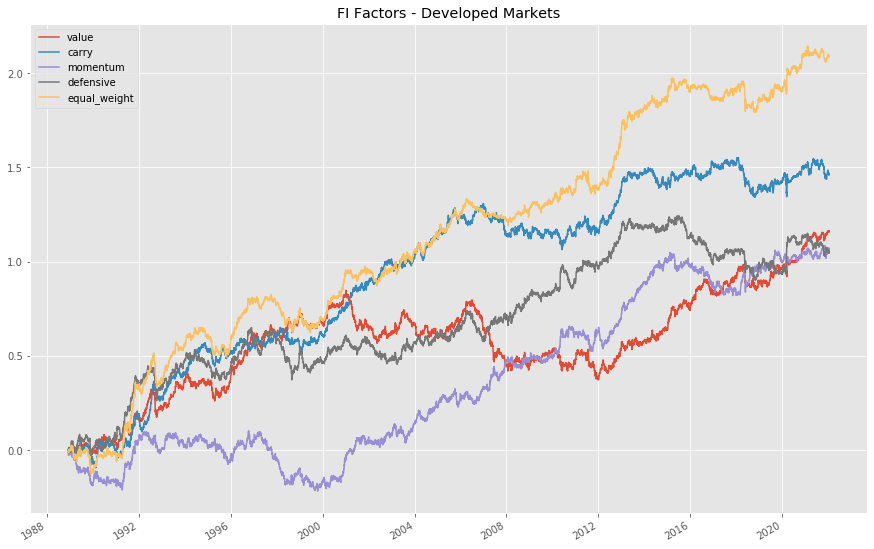

In [153]:
fi_strat_df.dropna().apply(lambda x: x*((0.10/np.sqrt(252))/x.std())).cumsum().plot()
plt.title('FI Factors - Developed Markets')

In [154]:
fi_strat_df.astype(float).corr()

,value,carry,momentum,defensive,equal_weight
value,1.000000,0.194802,-0.155371,0.429960,0.646895
carry,0.194802,1.000000,0.081323,0.061754,0.582686
momentum,-0.155371,0.081323,1.000000,-0.032759,0.401006
defensive,0.429960,0.061754,-0.032759,1.000000,0.644601
equal_weight,0.646895,0.582686,0.401006,0.644601,1.000000


In [553]:
# gdp_meta = pd.read_csv('gdp_usd.csv')
# gdp_meta['TIME'] = pd.PeriodIndex(gdp_meta['TIME'].values, freq='Q').to_timestamp(how='e')
# gdp_meta = pd.pivot_table(gdp_meta, values='Value',index='TIME', columns='LOCATION')
# gdp_meta.index = pd.to_datetime(gdp_meta.index.strftime('%Y-%m-%d'))
# gdp_countries = ['AUD', 'CAD', 'CHF', 'DEM', 'EUR', 'FRF', 'GBP', 'ITL', 'JPY', 'NOK', 'NZD', 'SEK']
# gdp_meta.columns = gdp_countries
# gdp_meta = gdp_meta.shift(1)

# gdp_weights = pd.DataFrame(index=bab_df.index, columns=bab_df.columns)
# gdp_weights[gdp_weights.columns] = gdp_meta[gdp_weights.columns].dropna(how='all').copy()
# gdp_weights = gdp_weights.fillna(method='ffill')
# gdp_weights.loc[~bab_df['EUR'].isnull(),['ITL', 'FRF', 'DEM']] = np.nan
# gdp_weights.loc[bab_df['EUR'].isnull(),'EUR'] = np.nan
# gdp_weights.dropna(how='all', inplace=True)
# gdp_weights = gdp_weights.apply(lambda x: x/np.nansum(x), axis=1)

In [604]:
dep_3m_df_final = pd.concat([dep_3mbbg_df, dep_3m_df[fx_ids[-3:]]], axis=1).fillna(dep_3m_df)
fxsp_bbg_df = fxsp_bbg_df.fillna(fxsp_df)
rx_df = (1 + dep_3m_df_final.loc[:,'CAD':]/(100*252)).multiply(fxsp_bbg_df.divide(fxsp_bbg_df.shift(1))).\
                                    subtract((1 + dep_3m_df_final['USD']/(252*100)).squeeze(), axis=0).loc['1986/01':].dropna(how='all')
rx_df.loc[~rx_df['EUR'].isnull(), ['ITL', 'FRF', 'DEM']] = np.nan

In [606]:
def get_risk_weights_fx(weights, vol_tgt=0.10):
    w_vec = weights.dropna().copy()
    cov = cov_system_fx.loc[w_vec.name].loc[w_vec.index, w_vec.index]
    risk_weights = w_vec*(vol_tgt/np.sqrt(w_vec.T.dot(cov).dot(w_vec)))
    weights.loc[w_vec.index] = risk_weights.copy()
    return weights

def post_eu_cov(cov):
    level_val = cov.index.get_level_values(0)[0].strftime('%Y-%m-%d')
    cov.loc[(level_val,['ITL', 'FRF', 'DEM'])] = np.nan
    cov.loc[(level_val,['ITL', 'FRF', 'DEM']),:] = np.nan    
    return cov

def get_cov_df(vols, corrmat):
    main_corr = corrmat.copy()
    assets = vols.dropna(axis=1).columns
    corr_mod = corrmat.loc[assets, assets]
    cov_new = pd.DataFrame(index=main_corr.columns,
                           columns=main_corr.columns)
    cov_new.loc[corr_mod.columns, corr_mod.columns] = corr2cov(vols.dropna(axis=1).values,
                                                               corr_mod.values)
    return cov_new

def get_risk_system_fx(df, freq='M'):
    
    eur_na_start = df['EUR'].isnull().sum()
    df['EUR'].iloc[(eur_na_start-63):eur_na_start] = \
        df.iloc[(eur_na_start-63):eur_na_start][['ITL', 'FRF', 'DEM']].mean(axis=1)
    pair_vols = (df.ewm(span=252, min_periods=63).std().dropna(how='all')*np.sqrt(252))
    pair_corr = df.ewm(span=3*252, min_periods=63).corr().dropna(how='all').loc[pair_vols.index]
    
    euro_ix = df.iloc[eur_na_start:].index
    pair_vols.loc[euro_ix, ['ITL', 'FRF', 'DEM']] = np.nan
    pair_corr.loc[euro_ix] = pair_corr.loc[euro_ix].\
                                groupby(level=0, axis=0).apply(post_eu_cov)
    
    cov_mat_df = pair_vols.groupby(level=0, axis=0).\
        apply(lambda x: get_cov_df(x, pair_corr.loc[x.name]))
    cov_mat_resamp = cov_mat_df.unstack().resample(freq).last().stack()    
    return cov_mat_resamp

cov_system_fx = get_risk_system_fx(rx_df, freq='M')
ix_start = np.unique(cov_system_fx.index.get_level_values(0))[0]
asset_list = cov_system_fx.groupby(level=0, axis=0).\
                apply(lambda x: pd.Series(x.dropna(how='all', axis=1).columns))

In [609]:
carry = ((dep_3m_df_final.loc[:,'CAD':].subtract(dep_3m_df_final['USD'].squeeze(), axis=0)/100)).\
        multiply((1+dep_3m_df_final['USD'].squeeze()/100)**(-1), axis=0)
carry.index.name = None
carry_signal_df = carry.resample('M').last().\
                    loc[ix_start:].apply(pick_assets, axis=1)
carry_signal_df.loc[~carry_signal_df['EUR'].isnull(), ['ITL', 'FRF', 'DEM']] = np.nan

carry_weights = carry_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]
carry_weights = carry_weights.apply(get_risk_weights_fx, axis=1)
carry_weights['Date'] = carry_weights.index

In [611]:
carry_rets, w_carry_df = get_ports(carry_weights, rx_df, fx_ids[1:])

In [660]:
def get_bskt_betas(df):
    fx_vol = df.rolling(252).std()
    bskt_vol = fx_bskt['fx_factor'].rolling(252).std()
    temp = pd.concat([fx_bskt, df], axis=1).rolling(3).mean()
    bskt_corr = temp.rolling(252*3).corr(temp[df.name])['fx_factor']
    return bskt_corr.multiply(fx_vol.divide(bskt_vol, axis=0))

bab_df = (1 + dep_3m_df_final.loc[:,'CAD':]/(100*252)).multiply(fxsp_bbg_df.divide(fxsp_bbg_df.shift(1))).\
                                    subtract((1 + dep_3m_df_final['USD']/(252*100)).squeeze(), axis=0).loc['1986/01':].dropna(how='all')

ids_pre_eu = ['CAD', 'AUD', 'CHF', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'ITL', 'FRF', 'DEM']
ids_post_eu = ['CAD', 'AUD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK']

fx_bskt = pd.DataFrame(index=bab_df.index, columns=['fx_factor'])
fx_bskt.loc[bab_df['EUR'].isnull(), 'fx_factor'] = bab_df.loc[bab_df['EUR'].isnull(), ids_pre_eu].mean(axis=1)
fx_bskt.loc[~bab_df['EUR'].isnull(), 'fx_factor'] = bab_df.loc[~bab_df['EUR'].isnull(), ids_post_eu].mean(axis=1)

eu_proxy =  bab_df[['ITL','FRF','DEM']].mean(axis=1)
eu_proxy.name = 'EUR'

shrink = 0.60
betas_df = bab_df.apply(get_bskt_betas)
betas_df.loc['1998-12-14':'2000-11-16','EUR'] = get_bskt_betas(eu_proxy).loc['1998-12-14':'2000-11-16']
betas_df = (shrink*betas_df) + (1-shrink)*1.0

bab_signal_df = (-betas_df).resample('M').last()[ix_start:].apply(pick_assets, axis=1)
bab_signal_df.loc[~bab_signal_df['EUR'].isnull(), ['ITL', 'FRF', 'DEM']] = np.nan

bab_weights = bab_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]

bab_weights = bab_weights.apply(get_risk_weights_fx, axis=1)
bab_weights['Date'] = bab_weights.index

In [615]:
mom_signal_df = (1+rx_df).cumprod().apply(get_mom_sig).resample('M').last().\
                    loc[ix_start:].apply(pick_assets, axis=1)
mom_signal_df.loc[~mom_signal_df['EUR'].isnull(), ['ITL', 'FRF', 'DEM']] = np.nan

mom_weights_cs = mom_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                        apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]
mom_weights_ts = mom_signal_df.apply(np.sign).apply(lambda x: x*(1/np.nansum(np.abs(x))), axis=1).dropna(how='all')[ix_start:]

mom_weights_cs = mom_weights_cs.apply(get_risk_weights_fx, axis=1)
mom_weights_ts = mom_weights_ts.apply(get_risk_weights_fx, axis=1)

mom_weights_ts['Date'] = mom_weights_ts.index
mom_weights_cs['Date'] = mom_weights_cs.index

In [617]:
momcs_rets, w_momcs_df = get_ports(mom_weights_cs, rx_df, fx_ids[1:])
momts_rets, w_momts_df = get_ports(mom_weights_ts, rx_df, fx_ids[1:])

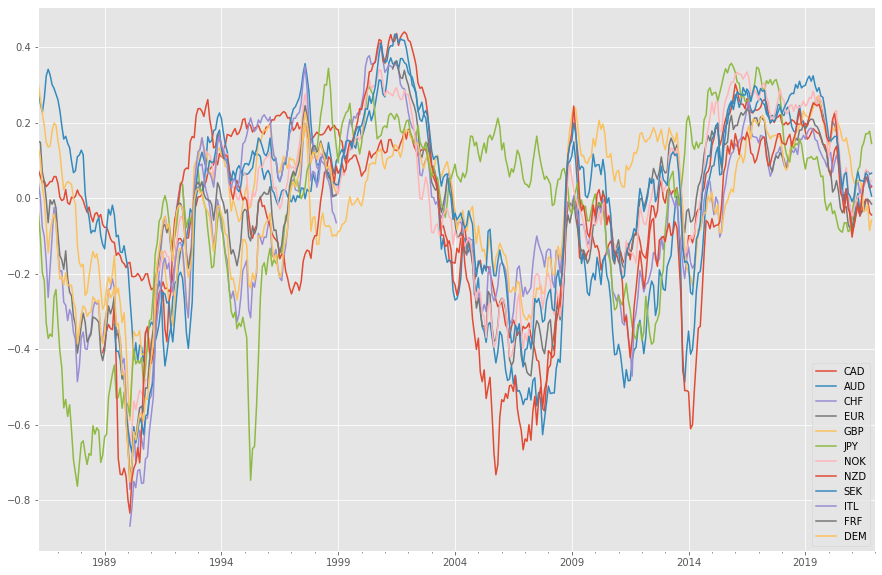

In [730]:
value_signal_df.plot()

In [627]:
value_signal_df = fxsp_bbg_df.resample('M').mean().apply(get_val_ppp).\
                    loc[ix_start:].apply(pick_assets, axis=1)
value_signal_df.loc[~value_signal_df['EUR'].isnull(), ['ITL', 'FRF', 'DEM']] = np.nan
value_weights = value_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]

value_weights = value_weights.apply(get_risk_weights_fx, axis=1)
value_weights['Date'] = value_weights.index

In [628]:
value_rets, w_value_df = get_ports(value_weights, rx_df, fx_ids[1:])

In [629]:
def get_tail_risk_betas(df):
    reg_df = pd.concat([tailrisk_df, df], axis=1).dropna()
    endog = reg_df[df.name]
    exog = sm.add_constant(reg_df[['PPUT Index', 'SPX Index']])
    rols = RollingOLS(endog, exog, window=3*252)
    rres = rols.fit()
    params = rres.params.copy()
    return params['PPUT Index']

put_data = sl.signal_get_data(['PPUT Index'],
                              fields='PX_LAST', startdate='19850101').pull()
spx_data = sl.signal_get_data(['SPX Index'], 
                              fields='TOT_RETURN_INDEX_GROSS_DVDS', startdate='19850101').pull()
tailrisk_df = put_data.apply(log).diff().subtract(spx_data['SPX Index'].apply(log).diff(), axis=0).dropna()
tailrisk_df['SPX Index'] = spx_data['SPX Index'].apply(np.log).diff()

tailfx_df = (1 + dep_3m_df_final.loc[:,'CAD':]/(100*252)).multiply(fxsp_bbg_df.divide(fxsp_bbg_df.shift(1))).\
                                    subtract((1 + dep_3m_df_final['USD']/(252*100)).squeeze(), axis=0).loc['1986/01':].dropna(how='all')
ids_pre_eu = ['CAD', 'AUD', 'CHF', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'ITL', 'FRF', 'DEM']
ids_post_eu = ['CAD', 'AUD', 'CHF', 'EUR', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK']

eu_proxy =  tailfx_df[['ITL','FRF','DEM']].mean(axis=1)
eu_proxy.name = 'EUR'

# shrink = 0.60
tail_betas_df = tailfx_df.apply(get_tail_risk_betas)
tail_betas_df.loc['1998-12-14':'2000-11-16','EUR'] = get_tail_risk_betas(eu_proxy).loc['1998-12-14':'2000-11-16']
# betas_df = (shrink*betas_df) + (1-shrink)*1.0

In [630]:
tail_signal_df = (-tail_betas_df).resample('M').last().\
                    loc[ix_start:].apply(pick_assets, axis=1)
tail_signal_df.loc[~tail_signal_df['EUR'].isnull(), ['ITL', 'FRF', 'DEM']] = np.nan

tail_weights = tail_signal_df.rank(axis=1).apply(lambda x: (x - x.mean())/x.std(), axis=1).apply(np.clip, args=((-2,2,))).\
                                apply(lambda x: (2*x)/np.nansum(np.abs(x)), axis=1).dropna(how='all')[ix_start:]

tail_weights = tail_weights.apply(get_risk_weights_fx, axis=1)
tail_weights['Date'] = tail_weights.index

In [631]:
tail_rets, w_tail_df = get_ports(tail_weights, rx_df, fx_ids[1:])

In [636]:
strat_df = pd.concat([value_rets['PORT'], carry_rets['PORT'], 
                      momcs_rets['PORT'], momts_rets['PORT'], 
                      tail_rets['PORT']], 
                     axis=1)
strat_df.columns = ['value', 'carry', 'momentum_cs',  'momentum_ts', 'tail_risk']
strat_df['equal_weight'] = strat_df[['value', 'carry', 'momentum_cs', 'momentum_ts', 'tail_risk']].mean(axis=1)
strat_df.dropna().apply(get_stats, args=(252,))

,value,carry,momentum_cs,momentum_ts,tail_risk,equal_weight
Arith. Mean,0.028955,0.041601,0.015471,0.049005,0.037650,0.034536
Compound Mean,0.022280,0.036593,0.009830,0.044233,0.030740,0.033731
Volatility,0.117632,0.106039,0.106692,0.106944,0.121448,0.052134
SR,0.246147,0.392320,0.145004,0.458232,0.310007,0.662458
t-Stat,1.431160,2.281050,0.843091,2.664280,1.802462,3.851697
Max DD,0.387918,0.385639,0.482333,0.365110,0.326777,0.226738
Skewness,0.026399,-1.432360,0.120204,-0.053625,0.106644,-0.448847
Kurtosis,6.934593,19.283993,6.361243,2.413951,7.348121,8.843282


Text(0.5, 1.0, 'FX Factors - Developed Markets')

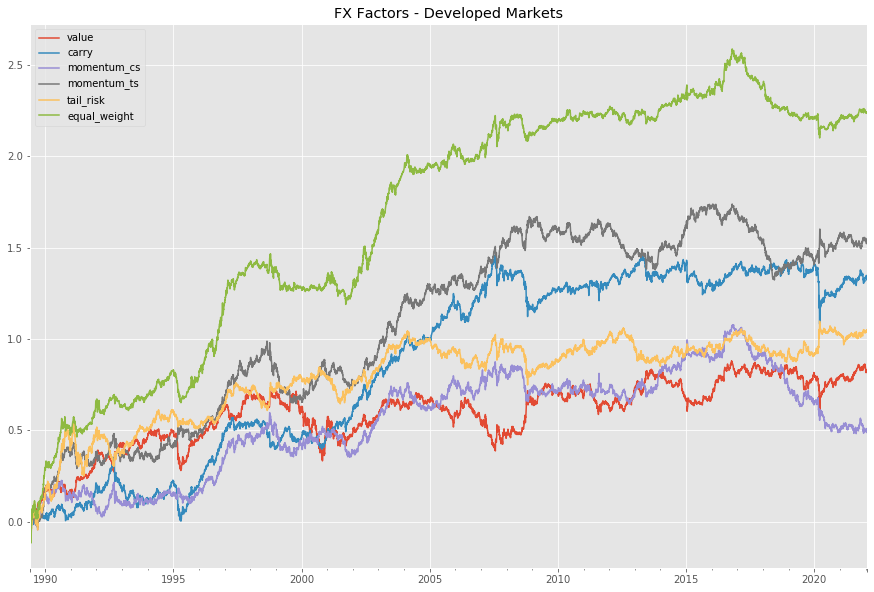

In [640]:
strat_df.dropna().apply(lambda x: x*((0.10/np.sqrt(252))/x.std())).cumsum().plot()
plt.title('FX Factors - Developed Markets')

In [645]:
strat_df.astype(float).corr()

,value,carry,momentum_cs,momentum_ts,tail_risk,equal_weight
value,1.000000,0.052907,-0.162430,-0.178893,-0.139699,0.310555
carry,0.052907,1.000000,0.206201,0.050915,0.083819,0.549409
momentum_cs,-0.162430,0.206201,1.000000,0.444236,0.072211,0.606292
momentum_ts,-0.178893,0.050915,0.444236,1.000000,0.111206,0.552945
tail_risk,-0.139699,0.083819,0.072211,0.111206,1.000000,0.512144
equal_weight,0.310555,0.549409,0.606292,0.552945,0.512144,1.000000


Text(0.5, 1.0, '5 Year Rolling Sharpe Ratio')

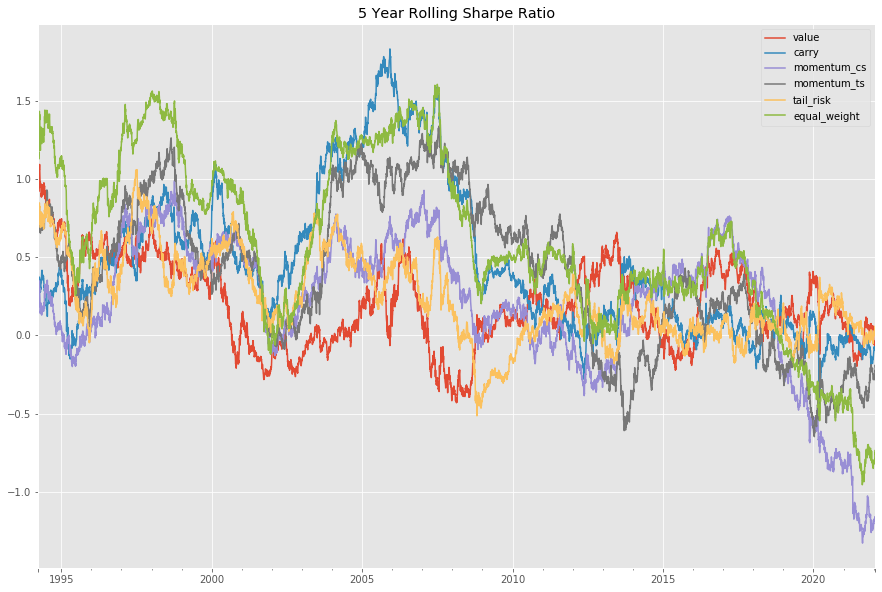

In [647]:
strat_df.dropna().rolling(5*252).apply(lambda x: x.mean()*15.9/x.std()).dropna().plot()
plt.title('5 Year Rolling Sharpe Ratio')

In [655]:
ir_anal = pd.concat([strat_df.astype(float), dep_3m_df_final['USD'].diff(1)/100], axis=1)
ir_anal['US3m_bucket'] = pd.qcut(ir_anal['USD'], 4)
(ir_anal.groupby('US3m_bucket')[['value', 'carry', 'momentum_cs', 'momentum_ts','tail_risk']].mean()*252).T

US3m_bucket,"(-0.00662, -1.5e-05]","(-1.5e-05, 0.0]","(0.0, 2.76e-05]","(2.76e-05, 0.0057]"
value,0.053293,0.028582,0.029786,0.033656
carry,-0.004174,0.034760,-0.009878,0.126471
momentum_cs,-0.035388,0.043599,0.003351,0.019106
momentum_ts,-0.045824,0.087297,0.007938,0.103104
tail_risk,0.045277,0.044024,0.007477,0.032895
